In [1]:
# ======================================================
# 1️⃣ Importar librerías necesarias
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)



✈️ Arribos: 25802 | 🛫 Despegues: 25894

✅ Transformación completada. Vista previa del flujo horario enriquecido:


,hour,arrival_count_hourly,departure_count_hourly,flight_count_hourly,gate_usage_rate,airline_activity_index,aircraft_mix_index,turnaround_overlap,hour_of_day,weekday,month,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,2025-06-30 15:00:00,1,0,1,0.02,1.0,NaN,0,15,0,6,-0.707107,-7.071068e-01,0.000000,1.00000,1.224647e-16,-1.000000
1,2025-06-30 17:00:00,1,0,1,0.02,1.0,NaN,0,17,0,6,-0.965926,-2.588190e-01,0.000000,1.00000,1.224647e-16,-1.000000
2,2025-06-30 18:00:00,0,1,1,0.02,1.0,NaN,0,18,0,6,-1.000000,-1.836970e-16,0.000000,1.00000,1.224647e-16,-1.000000
3,2025-06-30 23:00:00,2,0,2,0.04,1.0,1.0,0,23,0,6,-0.258819,9.659258e-01,0.000000,1.00000,1.224647e-16,-1.000000
4,2025-07-01 00:00:00,5,17,22,0.44,1.0,3.0,0,0,1,7,0.000000,1.000000e+00,0.781831,0.62349,-5.000000e-01,-0.866025


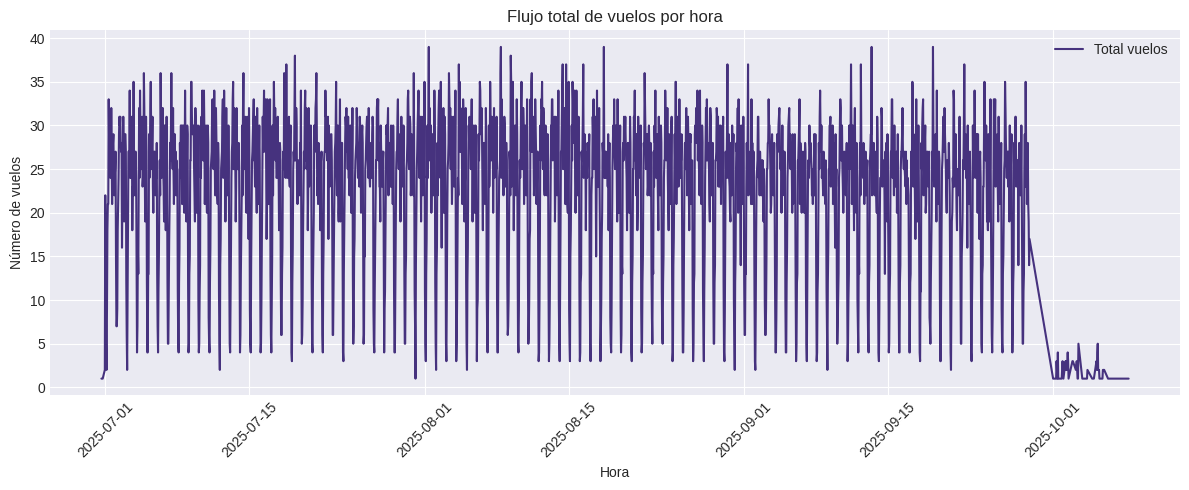

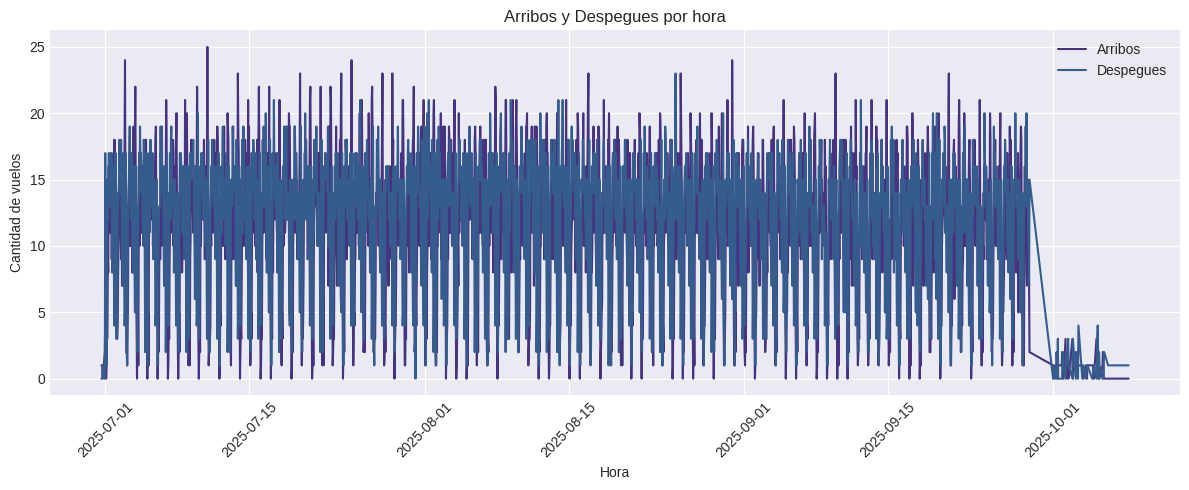

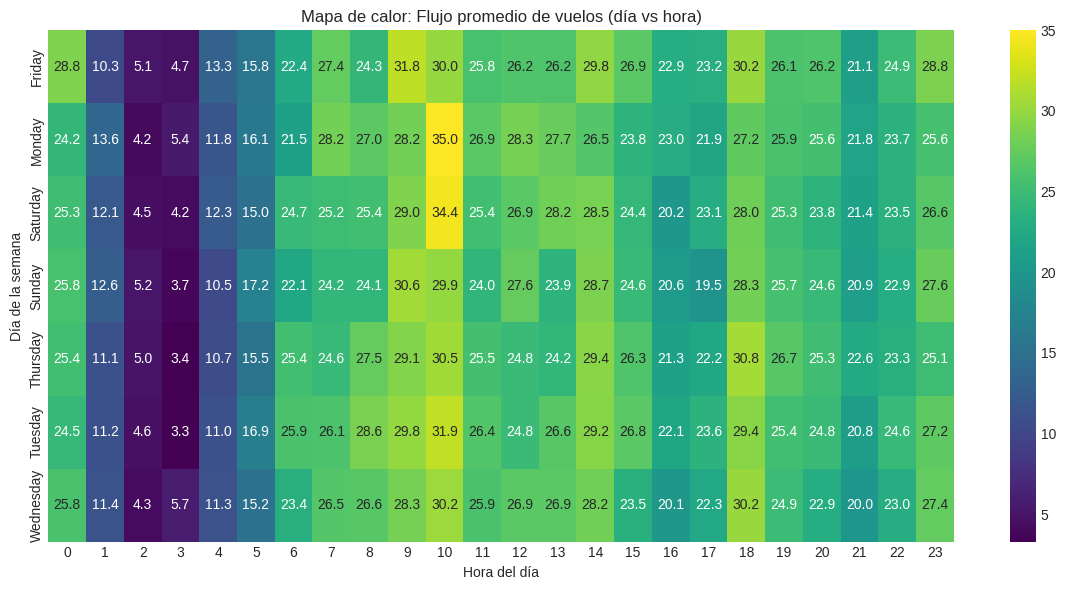

In [2]:
# ======================================================
# 2️⃣ Leer el archivo desde GitHub
# ======================================================
url = "https://raw.githubusercontent.com/anterotello/IA/main/data/raw/Dataset%20-%20Flujo%20horario.xlsx"
df = pd.read_excel(url)

# ======================================================
# 3️⃣ Limpieza y normalización básica
# ======================================================
df = df.drop_duplicates().reset_index(drop=True)
df.columns = df.columns.str.strip()

# Limpieza de valores tipo string (sin FutureWarning)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

# ======================================================
# 4️⃣ Conversión de columnas de fecha/hora
# ======================================================
datetime_cols = ['STA', 'STD', 'ETA', 'ETD', 'ATA', 'ATD', 'TDT', 'ABT']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# ======================================================
# 5️⃣ Variables derivadas básicas
# ======================================================

# Hora principal del evento (ETA para ARR, ETD para DEP)
df['hour'] = np.where(
    df['TOF'].str.upper() == 'ARR',
    df['ETA'].dt.floor('h'),
    df['ETD'].dt.floor('h')
)

# Retraso (en minutos)
df['delay'] = np.where(
    df['TOF'].str.upper() == 'ARR',
    (df['ATA'] - df['ETA']).dt.total_seconds() / 60,
    (df['ATD'] - df['ETD']).dt.total_seconds() / 60
)

# Día de la semana
df['day_of_week_flow'] = np.where(
    df['TOF'].str.upper() == 'ARR',
    df['ETA'].dt.day_name(),
    df['ETD'].dt.day_name()
)

# ======================================================
# 6️⃣ Separar datasets de arribos y despegues
# ======================================================
df_arribos = df[df['TOF'].str.upper() == 'ARR'].copy()
df_despegues = df[df['TOF'].str.upper() == 'DEP'].copy()

print(f"✈️ Arribos: {len(df_arribos)} | 🛫 Despegues: {len(df_despegues)}")

# ======================================================
# 7️⃣ BLOQUE: Agrupación por hora (flujo horario)
# ======================================================

TOTAL_GATES = 50  # ajustar según aeropuerto

flow_by_hour = (
    df.groupby(['hour', 'TOF'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'ARR': 'arrival_count_hourly', 'DEP': 'departure_count_hourly'})
    .reset_index()
)

flow_by_hour['flight_count_hourly'] = (
    flow_by_hour['arrival_count_hourly'] + flow_by_hour['departure_count_hourly']
)

# ======================================================
# 8️⃣ Variables adicionales
# ======================================================

# 🔹 Gate usage rate
flow_by_hour['gate_usage_rate'] = (flow_by_hour['flight_count_hourly'] / TOTAL_GATES).clip(upper=1)

# 🔹 Airline Activity Index
if 'PLT' in df.columns:
    airline_activity = (
        df.groupby(['hour', 'PLT'])
        .size()
        .reset_index(name='airline_ops')
    )
    airline_activity_index = (
        airline_activity.groupby('hour')['airline_ops']
        .mean()
        .reset_index(name='airline_activity_index')
    )
    flow_by_hour = flow_by_hour.merge(airline_activity_index, on='hour', how='left')
else:
    flow_by_hour['airline_activity_index'] = np.nan

# 🔹 Aircraft Mix Index
if 'TYS' in df.columns:
    aircraft_mix = (
        df.groupby(['hour', 'TYS'])
        .size()
        .reset_index(name='count')
    )
    aircraft_mix_index = (
        aircraft_mix.groupby('hour')['TYS']
        .nunique()
        .reset_index(name='aircraft_mix_index')
    )
    flow_by_hour = flow_by_hour.merge(aircraft_mix_index, on='hour', how='left')
else:
    flow_by_hour['aircraft_mix_index'] = np.nan

# 🔹 Turnaround overlap (vuelos con turnaround < 2h)
df['turnaround_overlap'] = np.where(
    (df['ATA'].notna()) & (df['ATD'].notna()) &
    ((df['ATD'] - df['ATA']).dt.total_seconds() / 3600 < 2),
    1, 0
)
turnaround = (
    df.groupby(df['hour'])['turnaround_overlap']
    .sum()
    .reset_index(name='turnaround_overlap')
)
flow_by_hour = flow_by_hour.merge(turnaround, on='hour', how='left')

# ======================================================
# 9️⃣ Variables temporales cíclicas
# ======================================================
flow_by_hour['hour_of_day'] = flow_by_hour['hour'].dt.hour
flow_by_hour['weekday'] = flow_by_hour['hour'].dt.weekday
flow_by_hour['month'] = flow_by_hour['hour'].dt.month

flow_by_hour['hour_sin'] = np.sin(2 * np.pi * flow_by_hour['hour_of_day'] / 24)
flow_by_hour['hour_cos'] = np.cos(2 * np.pi * flow_by_hour['hour_of_day'] / 24)
flow_by_hour['weekday_sin'] = np.sin(2 * np.pi * flow_by_hour['weekday'] / 7)
flow_by_hour['weekday_cos'] = np.cos(2 * np.pi * flow_by_hour['weekday'] / 7)
flow_by_hour['month_sin'] = np.sin(2 * np.pi * flow_by_hour['month'] / 12)
flow_by_hour['month_cos'] = np.cos(2 * np.pi * flow_by_hour['month'] / 12)

# ======================================================
# 🔟 Análisis Exploratorio y Visualización
# ======================================================

print("\n✅ Transformación completada. Vista previa del flujo horario enriquecido:")
display(flow_by_hour.head())

# --- Gráfico 1: Flujo total por hora ---
plt.figure(figsize=(12, 5))
sns.lineplot(data=flow_by_hour, x='hour', y='flight_count_hourly', label='Total vuelos')
plt.title('Flujo total de vuelos por hora')
plt.xlabel('Hora')
plt.ylabel('Número de vuelos')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Gráfico 2: Arribos vs Despegues ---
plt.figure(figsize=(12, 5))
sns.lineplot(data=flow_by_hour, x='hour', y='arrival_count_hourly', label='Arribos')
sns.lineplot(data=flow_by_hour, x='hour', y='departure_count_hourly', label='Despegues')
plt.title('Arribos y Despegues por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de vuelos')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Gráfico 3: Heatmap día de la semana vs hora ---
flow_by_hour['day_name'] = flow_by_hour['hour'].dt.day_name()
flow_by_hour['hour_of_day'] = flow_by_hour['hour'].dt.hour
pivot = flow_by_hour.pivot_table(values='flight_count_hourly', index='day_name', columns='hour_of_day', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title('Mapa de calor: Flujo promedio de vuelos (día vs hora)')
plt.xlabel('Hora del día')
plt.ylabel('Día de la semana')
plt.tight_layout()
plt.show()

# ======================================================
# 💾 Guardar dataset enriquecido (opcional)
# ======================================================
# flow_by_hour.to_csv("flujo_horario_enriquecido.csv", index=False)
